In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
importlib.reload(sys.modules['FetchModel'])
from FetchModel import FetchModel


c:\Users\matte\anaconda3\envs\stan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")

Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

phi = 62/3
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [19]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X_obs = X.drop(index=rows_to_drop_Y)
Y_obs = Y.drop(index=rows_to_drop_Y)
X_miss = X.loc[rows_to_drop_Y,:]
Y_miss = Y.loc[rows_to_drop_Y,:]

#saving the indexes of the dataframes
X_obs_index = X_obs.index
Y_obs_index = Y_obs.index
X_miss_index = X_miss.index
Y_miss_index = Y_miss.index

# If you want to reset the index after dropping rows
X_obs = X_obs.reset_index(drop=True)
Y_obs = Y_obs.reset_index(drop=True)
X_miss = X_miss.reset_index(drop=True)
Y_miss = Y_miss.reset_index(drop=True)

In [20]:
stations_obs = X_obs.loc[:,'Station']
years_raw_obs = X_obs.loc[:,'Year']
months_raw_obs = X_obs.loc[:,'Month']
years_obs = X_obs.loc[:,'Year'] - 2009
unique_values_obs = sorted(set(stations_obs))
mapping_dict_obs = {value: index + 1 for index, value in enumerate(unique_values_obs)}
transformed_stations_obs = [mapping_dict_obs[value] for value in stations_obs]

transformed_stations_obs = pd.Series(transformed_stations_obs)
years_obs = pd.Series(years_obs)
month_obs = pd.Series(months_raw_obs -3)

stations_miss = X_miss.loc[:,'Station']
years_raw_miss = X_miss.loc[:,'Year']
months_raw_miss = X_miss.loc[:,'Month']
years_miss = X_miss.loc[:,'Year'] - 2009
unique_values_miss = sorted(set(stations_miss))
mapping_dict_miss = {value_miss: index_miss + 1 for index_miss, value_miss in enumerate(unique_values_miss)}
transformed_stations_miss = [mapping_dict_miss[value_miss] for value_miss in stations_miss]

transformed_stations_miss = pd.Series(transformed_stations_miss)
years_miss = pd.Series(years_miss)
month_miss = pd.Series(months_raw_miss -3)

day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month_obs = []
max_month_miss = []

for i in range(0,X_obs.shape[0]):
    max_month_obs.append(day_in_month[X_obs['Month'][i]-1])

for i in range(0,X_miss.shape[0]):
    max_month_miss.append(day_in_month[X_miss['Month'][i]-1])
    
max_month_obs = pd.Series(max_month_obs)
max_month_miss = pd.Series(max_month_miss)

In [21]:
month_obs

0       1
1       2
2       3
3       4
4       5
       ..
3835    3
3836    4
3837    5
3838    6
3839    7
Name: Month, Length: 3840, dtype: int64

In [22]:
X_obs = X_obs.drop(['Year','Station','Month'], axis  = 1)
X_miss = X_miss.drop(['Year','Station','Month'], axis  = 1)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_obs_std = scaler.fit_transform(X_obs)
X_obs_std = pd.DataFrame(X_obs_std, columns=X_obs.columns)
X_obs_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_obs_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_obs_std.loc[:,"type_rural"] = pd.to_numeric(X_obs_std.loc[:,"type_rural"]).astype('Int64')
X_obs_std.loc[:,"type_urban"] = pd.to_numeric(X_obs_std.loc[:,"type_urban"]).astype('Int64')

X_miss_std = scaler.fit_transform(X_miss)
X_miss_std = pd.DataFrame(X_miss_std, columns=X_miss.columns)
X_miss_std.loc[:,"type_rural"] = X_miss.loc[:,"type_rural"]
X_miss_std.loc[:,"type_urban"] = X_miss.loc[:,"type_urban"]
X_miss_std.loc[:,"type_rural"] = pd.to_numeric(X_miss_std.loc[:,"type_rural"]).astype('Int64')
X_miss_std.loc[:,"type_urban"] = pd.to_numeric(X_miss_std.loc[:,"type_urban"]).astype('Int64')

In [8]:
Models_df = pd.DataFrame(columns=['MAE', 'MSE', 'inside CI', 'outliers'])

# Negative Binomial Model

In [13]:
model_120_neg_bin = FetchModel('model_120_neg_bin').compile()

22:40:54 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_neg_bin.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_neg_bin.exe
22:41:39 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_neg_bin.exe


In [14]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances
}

fit_120 = model_120_neg_bin.sample(data=data_120, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_neg_bin = az.from_cmdstanpy(fit_120)

22:41:39 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▊         | 00:00 Status

chain 1 |█▋        | 01:04 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 01:45 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 02:10 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 02:29 Iteration: 300 / 1000 [ 30%]  (Warmup)




chain 1 |█████▊    | 02:50 Iteration: 500 / 1000 [ 50%]  (Warmup)



chain 1 |██████▋   | 03:09 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 03:28 Iteration: 600 / 1000 [ 60%]  (Sampling)



chain 1 |████████▎ | 03:48 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 04:07 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 04:25 Sampling completed                      
chain 2 |██████████| 04:25 Sampling completed                      
chain 3 |██████████| 04:25 Sampling completed                      
chain 4 |██████████| 04:25 Sampling complet


22:46:05 - cmdstanpy - INFO - CmdStan done processing.
22:46:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'model_120_neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[2] is inf, but must be positive finite! (in 'model_120_neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in 'model_120_neg_bin.stan', line 66, column 2 to column 48)
	Exception: neg_binomial_2_lpmf: Location parameter[3] is inf, but must be positive finite! (in 'model_120_neg_bin.stan', line 66, column 2 to column 48)
	Exception: cholesky_decompose: Matrix m is not positive definite (in 'model_120_neg_bin.stan', line 50, column 2 to column 63)
	Exception: neg_binomial_2_lpmf: Location parameter[1] is inf, but must be positive finite! (in 'model_120_neg_bin.stan', line 66, colu

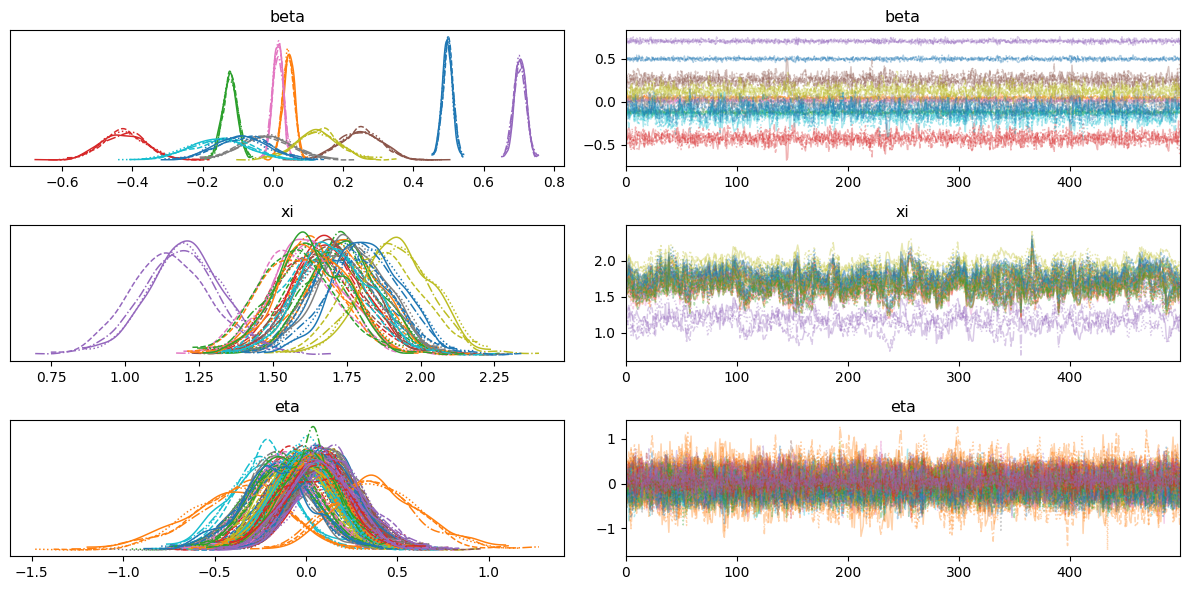

In [15]:
az.plot_trace(posterior_120_neg_bin, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [16]:
posterior_120_neg_bin

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [17]:
posterior_120_neg_bin_med = posterior_120_neg_bin.posterior.median(dim=['chain', 'draw'])
posterior_120_neg_bin_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, lambda_dim_0: 3840,
                           fix_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/16)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * lambda_dim_0          (lambda_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * fix_eff_dim_0         (fix_eff_dim_0) int32 0 1 2 3 ... 3836 3837 3838 3839
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/17)
    beta                  (beta_dim_0) float64 0.498 0.04505 ... -0.08853
    eta                   (eta_dim_0) float64 0.1225 -0.02527 ... 0.06621
    xi                    (xi_dim_0) float64 1.742 1.729 1.723 ... 1.621 1.609
    w                     (w_dim_0) float64 0.2936 0.1323 ... 0.2127 0.1194
    sigma                 float64 0.3066
    sigma0                float64 0.2331
    ...                    ...
    fix_eff_miss          (fix_eff_miss_dim_0) float64 0.1813 -0.8565 ... 0.3061
    intercept_miss        (intercept_miss_dim_0) float64 1.605 2.174 ... 2.003
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 0.09399 ... ...
    Lw                    (Lw_dim_0, Lw_dim_1) float64 0.3066 0.0 ... 0.244
    y_pred                (y_pred_dim_0) float64 3.0 5.0 16.0 ... 14.0 3.0 1.0
    y_pred_miss           (y_pred_miss_dim_0) float64 6.0 3.0 4.0 ... 1.0 10.0

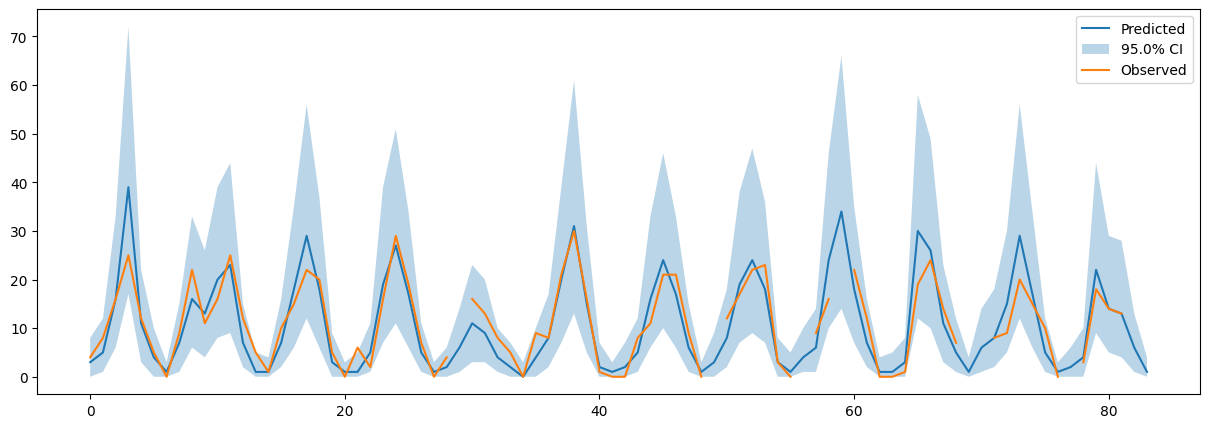

In [18]:
alpha = 0.05

posterior = posterior_120_neg_bin.posterior

y_pred_obs = posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_miss = posterior.y_pred_miss.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred = pd.concat([pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_obs_index),
                                  pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_miss_index)]).sort_index()
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_pred_miss = pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2*100}%'], y_pred.loc[xx, f'{(1-alpha/2)*100}%'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.show()


In [19]:
y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[  21  145  165  227  234  363  391  394  404  414  420  422  429  433
  478  479  481  486  488  493  512  581  585  599  609  650  665  669
  685  695  718  753  769  770  774  835  863  864  874  876  917  919
  920  921  950  955  984 1016 1019 1021 1022 1026 1073 1105 1146 1165
 1185 1222 1283 1331 1371 1552 1611 1631 1774 1786 1867 1869 1889 1903
 1953 1955 1983 1989 2050 2075 2076 2115 2127 2180 2198 2234 2251 2301
 2332 2363 2375 2382 2399 2458 2460 2464 2546 2574 2583 2624 2643 2652
 2670 2711 2718 2730 2737 2740 2748 2753 2765 2770 2785 2812 2832 2833
 2834 2867 2895 2910 2920 2972 3014 3020 3027 3074 3088 3152 3160 3161
 3232 3246 3322 3329 3359 3418 3427 3434 3446 3449 3472 3503 3523 3580
 3612 3640 3684 3747 3752 3773 3824]
(147,)


In [20]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

0.96171875


[   3   79  331  409  591  625  646  660  674  850  856  867  891  899
  913 1086 1121 1170 1177 1353 1387 1435 1533 1616 2033 2062 2072 2091
 2139 2175 2312 2387 2613 2620 2627 2634 2648 2655 2667 2686 2699 2700
 2707 2713 2714 2721 2727 2734 2735 2906 2913 2996 3003 3022 3035 3084
 3091 3122 3147 3341 3376 3396 3403 3423 3516 3545 3591 3598 3629 3656
 3664 3678 3757 3775 3788 3836]
(76,)
[   3   61  391  410  422  429  478  513  519  585  591  599  674  695
  701  850  863  867  876  884  920  950 1016 1021 1032 1086 1177 1222
 1407 1408 1527 1540 1889 1983 2026 2033 2140 2155 2175 2221 2251 2399
 2462 2580 2613 2648 2655 2663 2667 2699 2700 2718 2734 2735 2749 2832
 2833 2839 2873 2913 2920 2927 2988 3003 3014 3028 3041 3042 3055 3095
 3140 3147 3161 3390 3423 3522 3526 3607 3608 3694]
(80,)


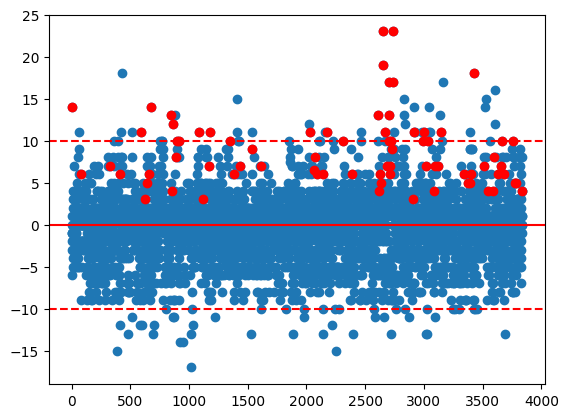

In [21]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res.values)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [22]:
mae = np.mean(residuals, axis=0)
print(mae)
mse = np.mean(residuals**2, axis=0)
print(mse)

2.956640625
16.709440104166667


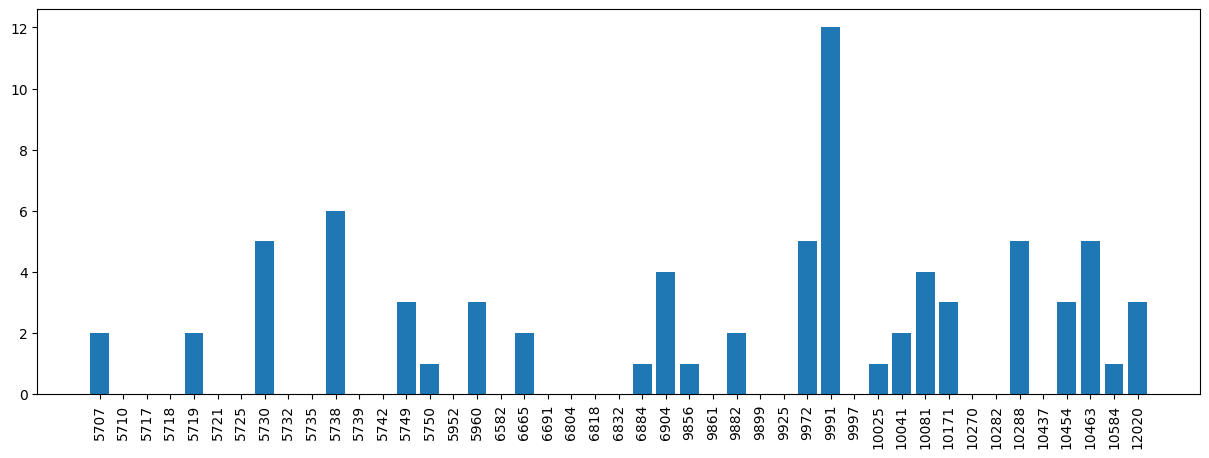

In [23]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

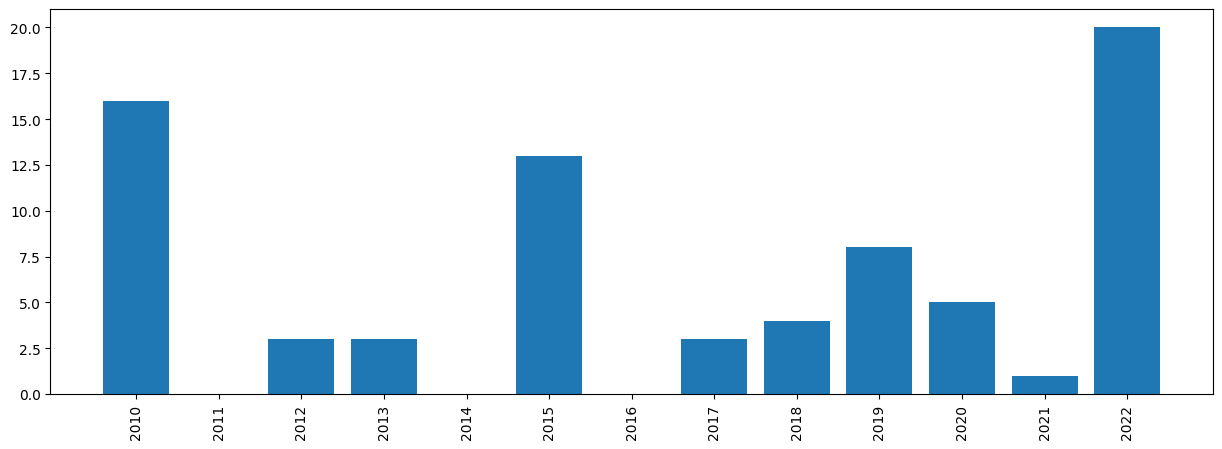

In [24]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

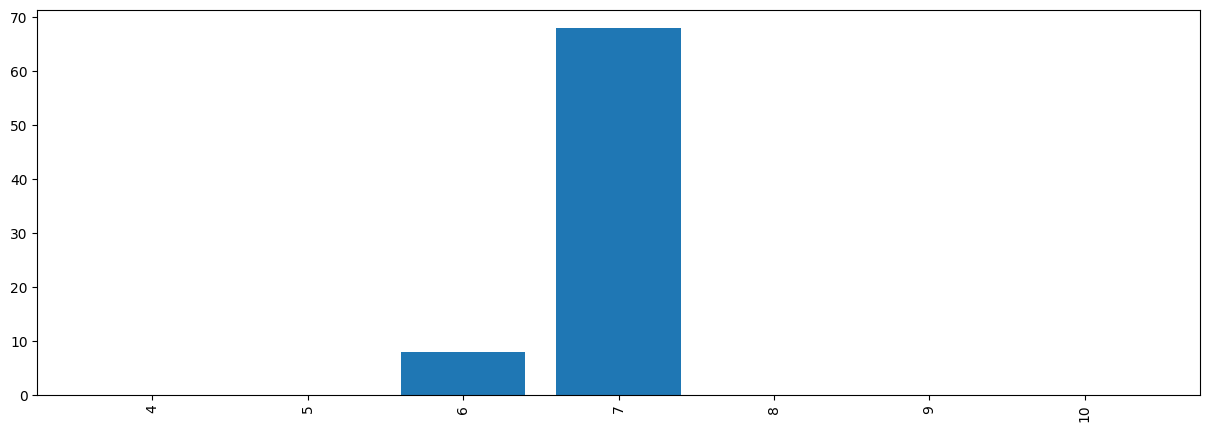

In [25]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month = outliers_per_month.sort_index()
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

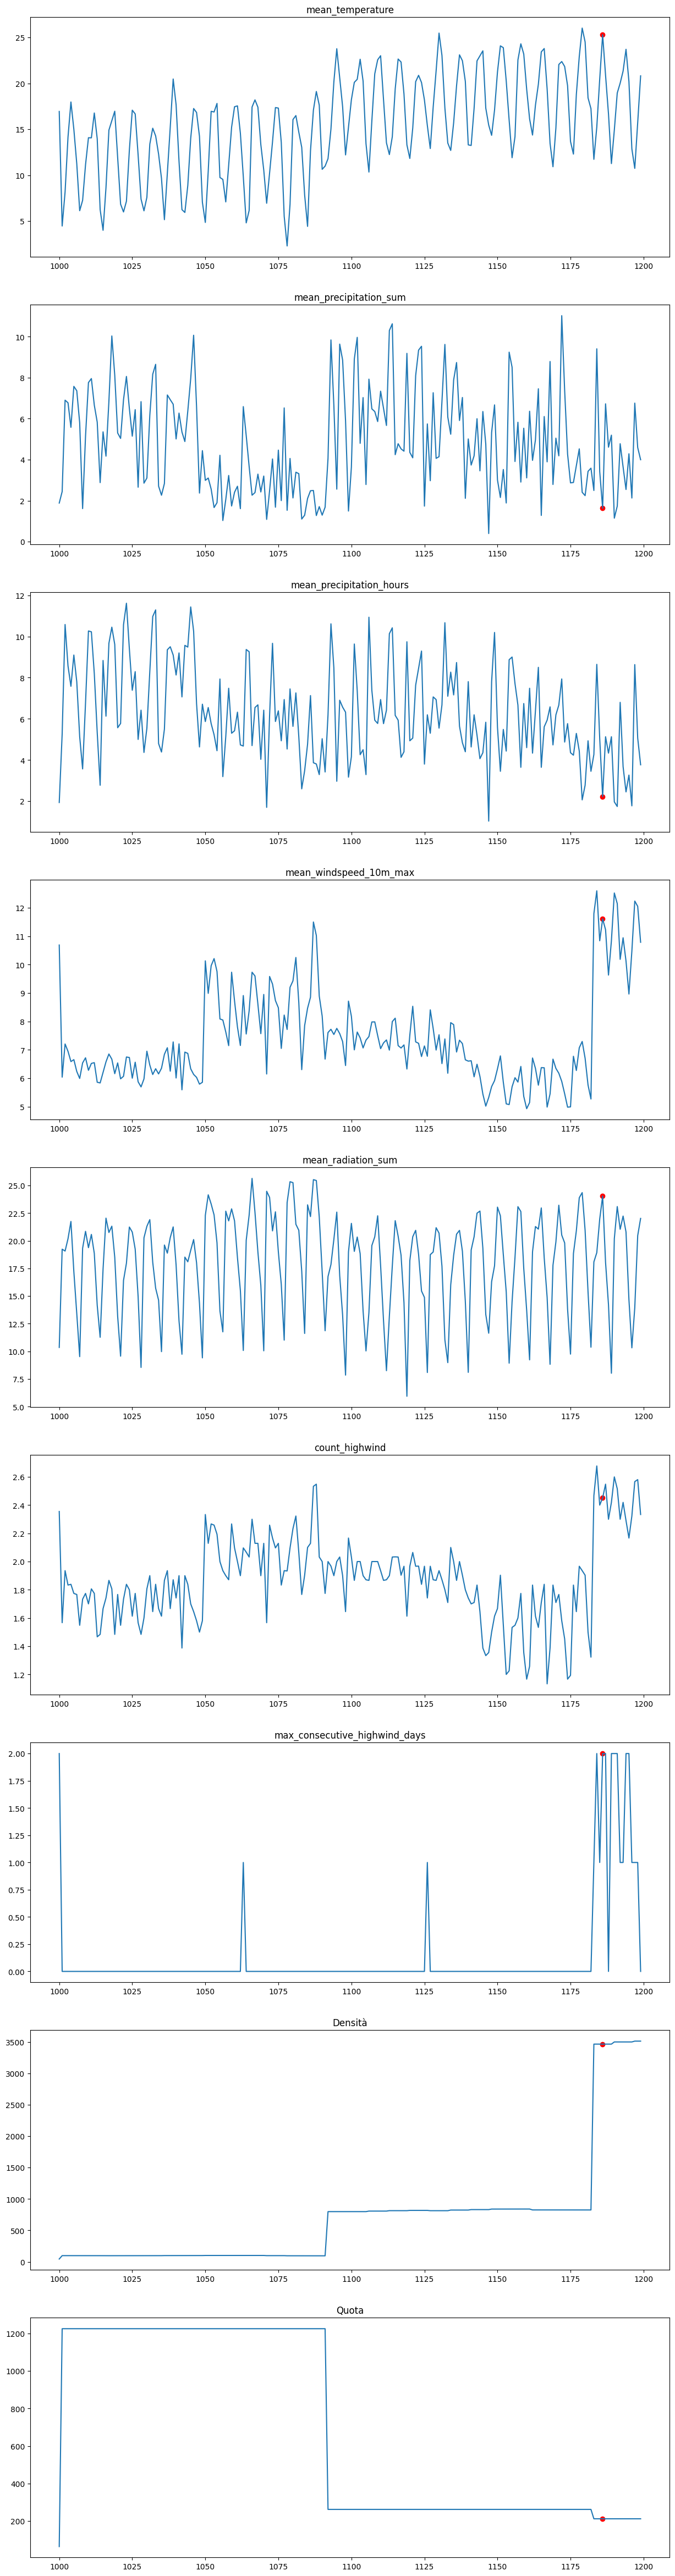

In [26]:
# Plotting covariates around the outliers
X_data = X.drop(['Year','Station','Month'], axis  = 1)
station_num_to_plot = -1 # Change this to plot different stations, -1 to choose manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
fig, axs = plt.subplots(9, 1, figsize=(15, 60))
for i in range(0,9):
    axs[i].plot(xx, X_data.iloc[:,i][xx])
    axs[i].scatter(np.intersect1d(X_obs_index[idx_over_max],xx), X_data.iloc[:,i][np.intersect1d(X_obs_index[idx_over_max],xx)], color='r')
    axs[i].set_title(X_data.columns[i])
plt.show()

In [27]:
Models_df.loc['model_120_neg_bin'] = [mae, mse, percentage_inside, idx_over_max.shape[0]]

# Truncated Poisson

In [40]:
model_120_trunc_poi = FetchModel('model_120_trunc_poi').compile()

23:27:07 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_trunc_poi.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_trunc_poi.exe
23:27:51 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_trunc_poi.exe


In [44]:
data_120_trunc_poi = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "U":31
}

fit_120_trunc_poi = model_120_trunc_poi.sample(data=data_120_trunc_poi, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_trunc_poi = az.from_cmdstanpy(fit_120_trunc_poi)

23:52:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▊         | 00:00 Status

chain 1 |█▋        | 00:03 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 00:11 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 00:15 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 00:20 Iteration: 300 / 1000 [ 30%]  (Warmup)

chain 1 |█████     | 00:26 Iteration: 400 / 1000 [ 40%]  (Warmup)


chain 1 |██████▋   | 00:34 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 00:43 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 00:50 Iteration: 700 / 1000 [ 70%]  (Sampling)




chain 1 |█████████▏| 00:58 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 01:03 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 01:11 Sampling completed                      
chain 2 |██████████| 01:11 Sampling completed                      
chain 3 |██████████| 01:11 Sampling completed  


23:53:42 - cmdstanpy - INFO - CmdStan done processing.
23:53:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_trunc_poi.stan', line 51, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_trunc_poi.stan', line 51, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'model_120_trunc_poi.stan', line 51, column 2 to column 63)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model_120_trunc_poi.stan', line 72, column 2 to column 26)
Consider re-running with show_console=True if the above output is unclear!


23:53:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


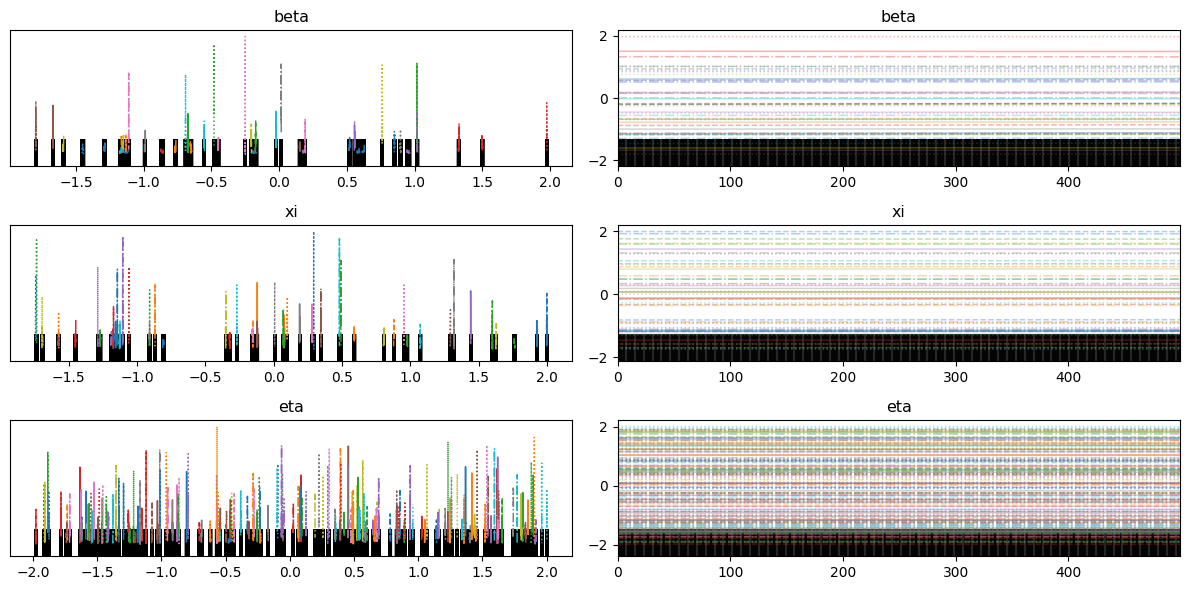

In [47]:
az.plot_trace(posterior_120_trunc_poi, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [48]:
posterior_120_trunc_poi

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [49]:
posterior_120_trunc_poi_med = posterior_120_trunc_poi.posterior.median(dim=['chain', 'draw'])
posterior_120_trunc_poi_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, lambda_dim_0: 3840,
                           fix_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/16)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * lambda_dim_0          (lambda_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * fix_eff_dim_0         (fix_eff_dim_0) int32 0 1 2 3 ... 3836 3837 3838 3839
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/16)
    beta                  (beta_dim_0) float64 0.603 -0.9504 ... -0.6231 -1.214
    eta                   (eta_dim_0) float64 -0.3948 1.091 ... -0.2032 0.4943
    xi                    (xi_dim_0) float64 -0.2558 -0.136 ... 0.08857 0.2816
    w                     (w_dim_0) float64 0.4736 0.09628 ... 1.757 -0.2835
    sigma                 float64 1.188
    sigma0                float64 2.701
    ...                    ...
    fix_eff_miss          (fix_eff_miss_dim_0) float64 -0.2574 -1.058 ... 0.7113
    intercept_miss        (intercept_miss_dim_0) float64 -0.5945 ... -0.6178
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 1.508 ... 1.508
    Lw                    (Lw_dim_0, Lw_dim_1) float64 1.188 0.0 ... 0.9455
    y_pred                (y_pred_dim_0) float64 0.0 0.0 3.0 ... 6.0 1.0 1.0
    y_pred_miss           (y_pred_miss_dim_0) float64 0.0 0.0 0.0 ... 0.0 2.0

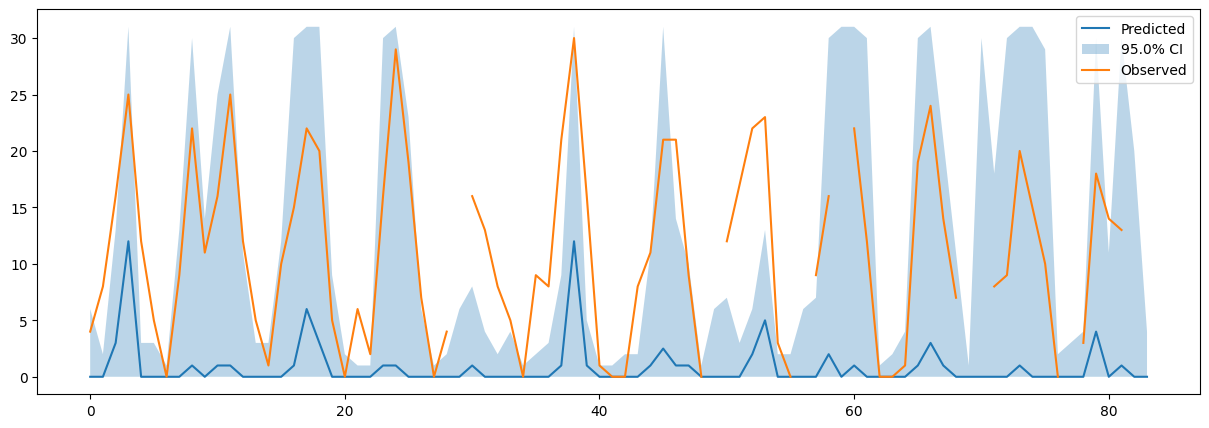

In [71]:
alpha = 0.05

posterior = posterior_120_trunc_poi.posterior

y_pred_obs = posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_miss = posterior.y_pred_miss.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred = pd.concat([pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_obs_index),
                                  pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_miss_index)]).sort_index()
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_pred_miss = pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2*100}%'], y_pred.loc[xx, f'{(1-alpha/2)*100}%'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.show()


In [51]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[   1    2    4 ... 3818 3823 3824]
(1122,)


In [52]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

0.7078125


[   3  591  674  867 1387 2139 2387 2648 2655 2699 2713 2734 2735 2906
 3035 3122 3423 3545 3656 3757 3788]
(21,)
[ 391  410  429  478  599  695  701  769  770  884  920  950 1016 1021
 1222 1407 1408 1527 1889 1978 1983 2026 2119 2140 2251 2399 2648 2666
 2699 2718 2734 2749 2761 2832 2833 2988 3014 3028 3095 3140 3161 3522
 3526 3607 3694]
(45,)


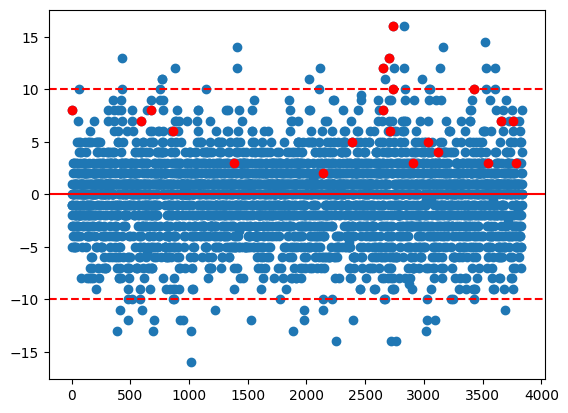

In [ ]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res.values)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [ ]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

2.738020833333333
13.435416666666667


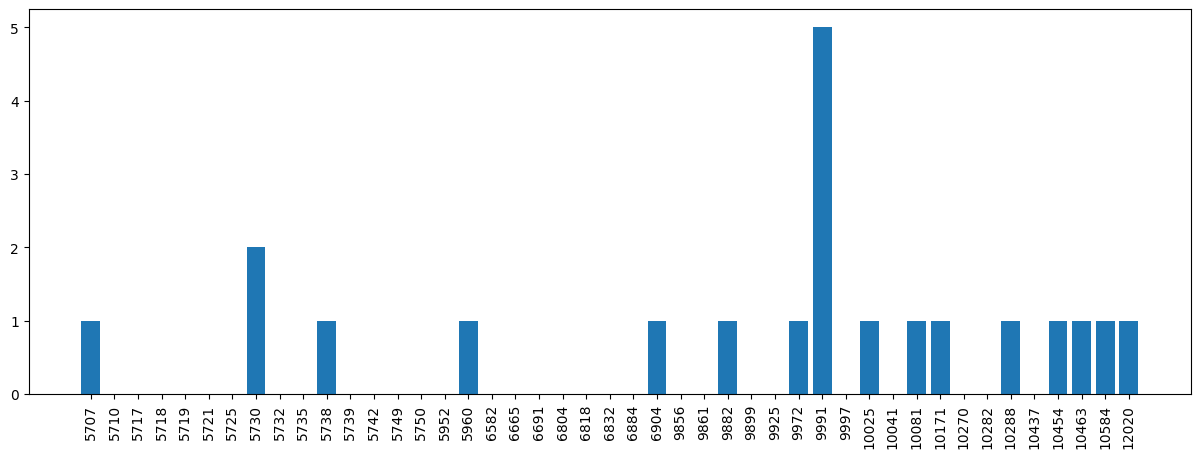

In [ ]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

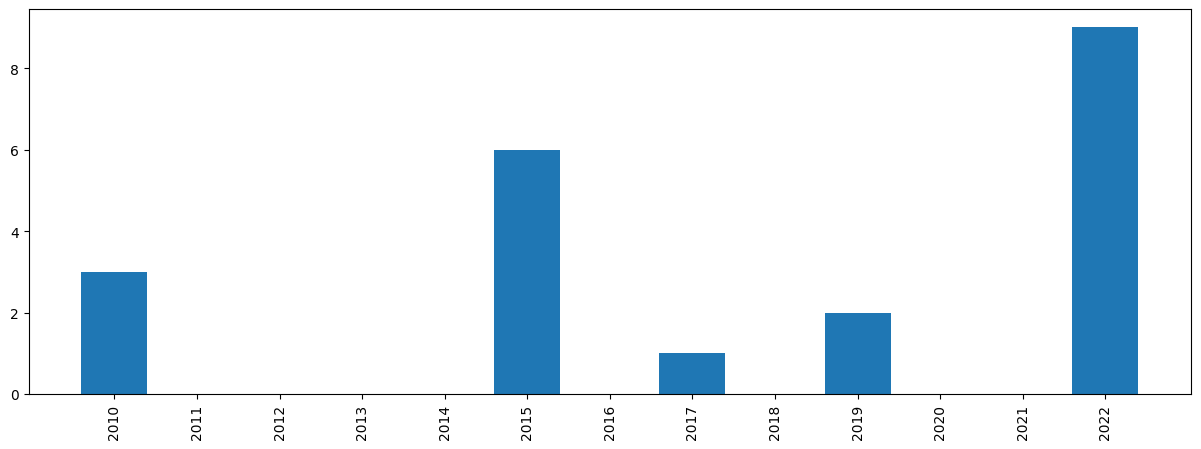

In [ ]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

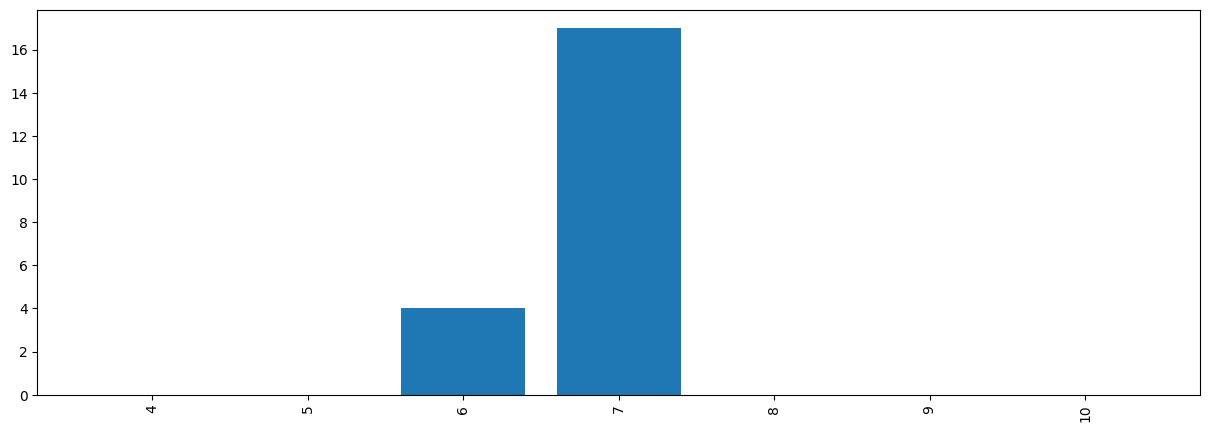

In [ ]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

In [ ]:
Models_df.loc['model_120_trunc_poi'] = [mae, mse, percentage_inside, idx_over_max.shape[0]]

# Double Poisson

In [24]:
model_120_dpo = FetchModel('model_120_dpo').compile()

In [25]:
data_120_dpo = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "nmonths": 7,
    "month": month_obs,
    "month_miss": month_miss
}

fit_120_dpo = model_120_dpo.sample(data=data_120_dpo, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_dpo = az.from_cmdstanpy(fit_120_dpo)

12:57:45 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Status







chain 1 |█▋        | 02:55 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 04:11 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 05:19 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 06:04 Iteration: 300 / 1000 [ 30%]  (Warmup)





chain 1 |█████▊    | 06:55 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 07:42 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 08:28 Iteration: 600 / 1000 [ 60%]  (Sampling)
chain 1 |████████▎ | 09:19 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 10:10 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 10:50 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 10:55 Sampling completed                      
chain 2 |██████████| 10:55 Sampling completed                      
chain 3 |██████████| 10:55 Sampling completed                      
chain 4 |██████████| 10:55 Sampling completed                      


13:08:40 - cmdstanpy - INFO - CmdStan done processing.
13:08:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo.stan', line 125, column 2 to column 63)
Exception: cholesky_decompos

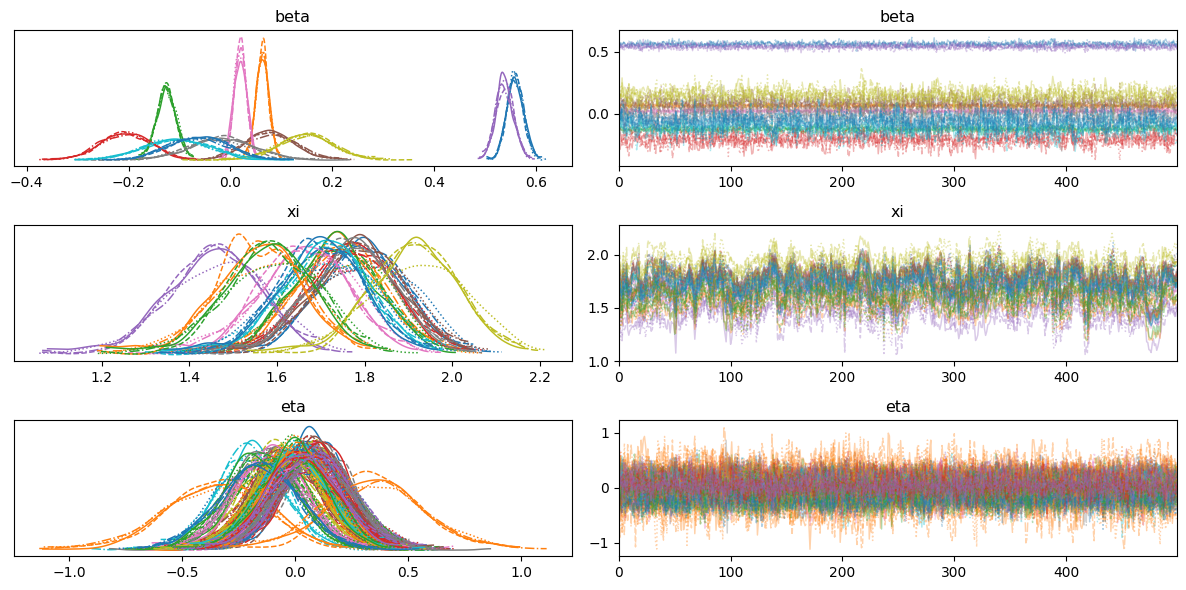

In [26]:
az.plot_trace(posterior_120_dpo, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [27]:
posterior_120_dpo

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [28]:
posterior_120_dpo_med = posterior_120_dpo.posterior.median(dim=['chain', 'draw'])
posterior_120_dpo_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, phi_dpo_dim_0: 7, lambda_dim_0: 3840,
                           fix_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/17)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * phi_dpo_dim_0         (phi_dpo_dim_0) int32 0 1 2 3 4 5 6
  * lambda_dim_0          (lambda_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/17)
    beta                  (beta_dim_0) float64 0.5587 0.06296 ... -0.06235
    eta                   (eta_dim_0) float64 0.09642 -0.02461 ... 0.04492
    xi                    (xi_dim_0) float64 1.793 1.743 1.736 ... 1.563 1.585
    w                     (w_dim_0) float64 0.2203 0.128 ... 0.1986 0.07787
    sigma                 float64 0.2603
    sigma0                float64 0.21
    ...                    ...
    fix_eff_miss          (fix_eff_miss_dim_0) float64 0.1062 -0.7741 ... 0.2765
    intercept_miss        (intercept_miss_dim_0) float64 1.779 2.092 ... 1.824
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 0.06774 ... ...
    Lw                    (Lw_dim_0, Lw_dim_1) float64 0.2603 0.0 ... 0.2072
    y_pred                (y_pred_dim_0) float64 3.0 4.0 14.0 ... 14.0 3.0 1.0
    y_pred_miss           (y_pred_miss_dim_0) float64 6.0 3.0 4.0 ... 1.0 8.0

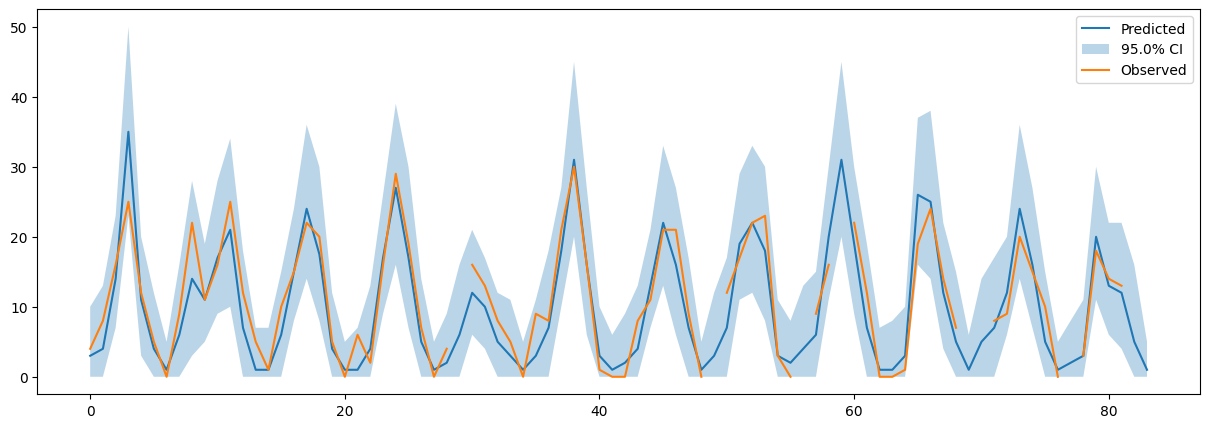

In [29]:
alpha = 0.05

posterior = posterior_120_dpo.posterior

y_pred_obs = posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_miss = posterior.y_pred_miss.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred = pd.concat([pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_obs_index),
                                  pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_miss_index)]).sort_index()
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_pred_miss = pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2*100}%'], y_pred.loc[xx, f'{(1-alpha/2)*100}%'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.show()

In [30]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[ 391  410  422  429  478  481  512  513  519  585  599  695  701  753
  757  769  770  775  781  863  864  876  917  919  920  921  950  962
  984 1016 1021 1073 1222 1331 1407 1527 1540 1774 1889 1978 1983 1989
 2026 2119 2140 2221 2227 2234 2251 2399 2460 2464 2711 2718 2740 2741
 2746 2748 2761 2766 2785 2812 2831 2832 2833 2920 3014 3020 3027 3028
 3041 3088 3095 3152 3161 3232 3319 3359 3427 3430 3434 3446 3449 3503
 3522 3526 3607 3608 3694 3741]
(90,)


In [31]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

0.9765625


[   3   79  409  591  625  674  867  913 1086 1121 1170 1177 1353 1387
 1435 1533 1616 1919 2091 2139 2387 2599 2648 2655 2686 2700 2734 2735
 2906 2913 2996 3035 3084 3122 3376 3423 3545 3629 3757 3788]
(40,)
[ 391  410  429  478  513  585  599  695  701  770  842  876  920  950
 1016 1021 1222 1407 1527 1889 1978 1983 2119 2137 2140 2221 2251 2399
 2648 2655 2659 2663 2718 2735 2746 2832 2833 3014 3028 3042 3095 3423
 3430 3522 3526 3600 3608 3694]
(48,)


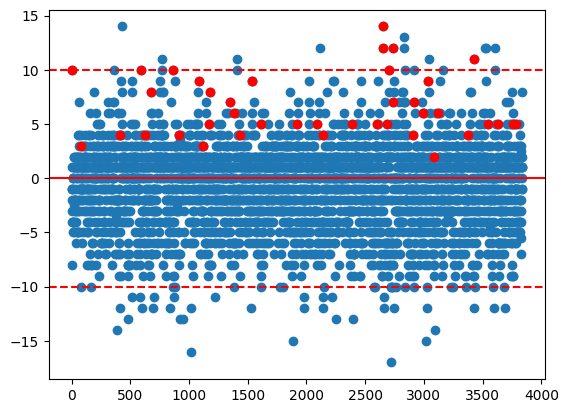

In [32]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res.values)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [33]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

2.761458333333333
13.736979166666666


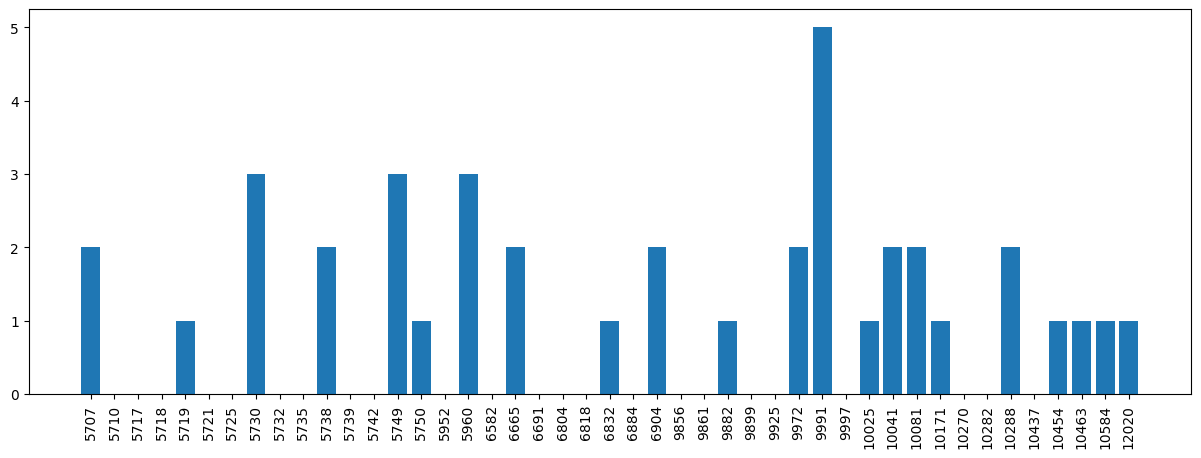

In [34]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

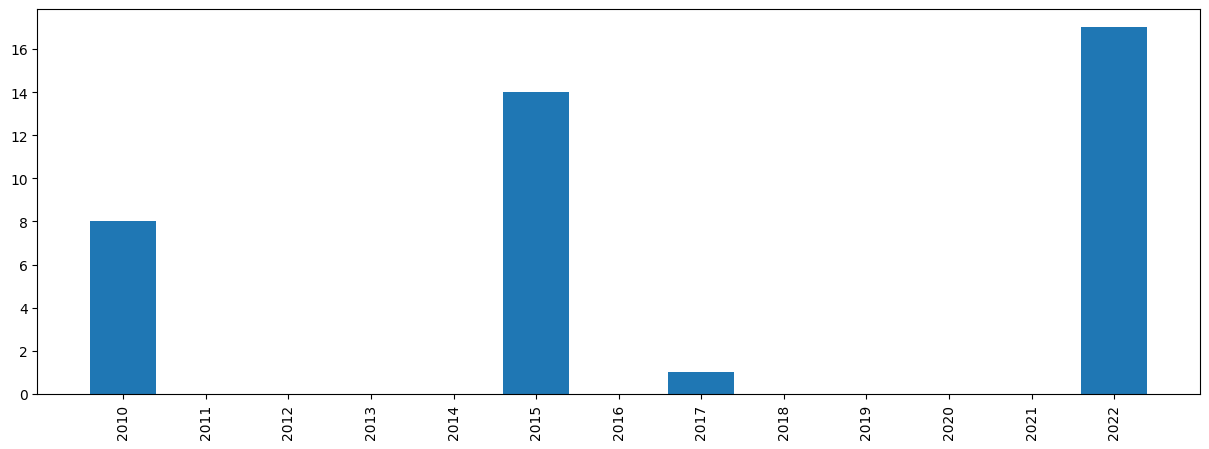

In [35]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

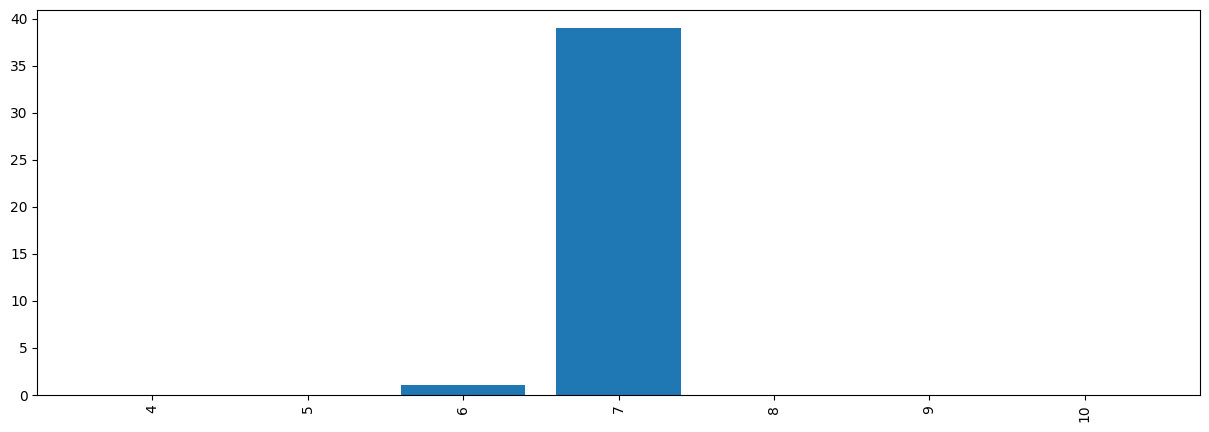

In [36]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

In [37]:
Models_df.loc['model_120_dpo'] = [mae, mse, percentage_inside, idx_over_max.shape[0]]

# DPO with dummy for july

In [38]:
months_to_repeat = [7]
dummy_july = np.zeros(X.shape[0])
idx_july = np.where(X['Month'].isin(months_to_repeat))[0]
dummy_july[idx_july] = 1
dummy_july_obs = pd.Series(dummy_july[X_obs_index])
dummy_july_miss = pd.Series(dummy_july[X_miss_index])

In [39]:
model_120_dpo_dummy = FetchModel('model_120_dpo_dummy').compile()

13:09:10 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_dpo_dummy.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_dpo_dummy.exe
13:09:59 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\model_120_dpo_dummy.exe


In [40]:
data_120_dpo_july = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'],
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances,
    "dummy_obs": dummy_july_obs,
    "dummy_miss": dummy_july_miss,
    "nmonths": 7,
    "month": month_obs,
    "month_miss": month_miss
}

fit_120_dpo_july = model_120_dpo_dummy.sample(data=data_120_dpo_july, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_dpo_july = az.from_cmdstanpy(fit_120_dpo_july)

13:10:00 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▊         | 00:00 Status
chain 1 |█▋        | 07:29 Iteration:   1 / 1000 [  0%]  (Warmup)

chain 1 |██▌       | 08:31 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 09:27 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 10:17 Iteration: 300 / 1000 [ 30%]  (Warmup)


chain 1 |█████▊    | 11:10 Iteration: 500 / 1000 [ 50%]  (Warmup)





chain 1 |██████▋   | 11:54 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 12:37 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 13:18 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 14:00 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 14:40 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 14:53 Sampling completed                      
chain 2 |██████████| 14:53 Sampling completed                      
chain 3 |██████████| 14:53 Sampling complete


13:24:53 - cmdstanpy - INFO - CmdStan done processing.
13:24:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_dpo_dummy.stan', line 131, column 2 to colu

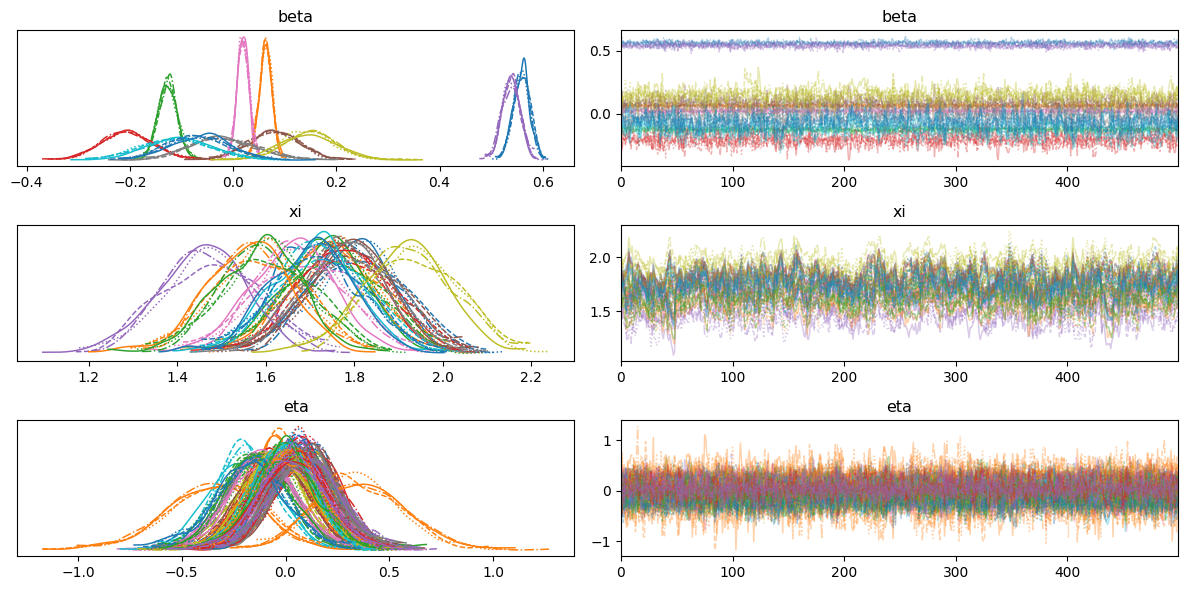

In [41]:
az.plot_trace(posterior_120_dpo_july, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [42]:
posterior_120_dpo_july

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

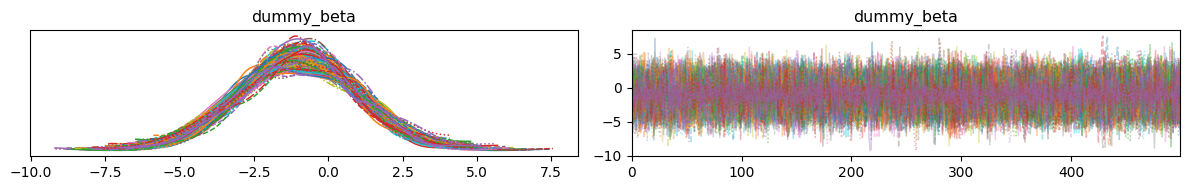

In [43]:
az.plot_trace(posterior_120_dpo_july, var_names=['dummy_beta'], compact=True)
plt.tight_layout()
plt.show()

In [44]:
posterior_120_dpo_july_med = posterior_120_dpo_july.posterior.median(dim=['chain', 'draw'])
posterior_120_dpo_july_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, phi_dpo_dim_0: 7, dummy_beta_dim_0: 45,
                           lambda_dim_0: 3840, fix_eff_dim_0: 3840,
                           dummy_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           dummy_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/20)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * phi_dpo_dim_0         (phi_dpo_dim_0) int32 0 1 2 3 4 5 6
  * dummy_beta_dim_0      (dummy_beta_dim_0) int32 0 1 2 3 4 ... 40 41 42 43 44
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/20)
    beta                  (beta_dim_0) float64 0.5593 0.06317 ... -0.06713
    eta                   (eta_dim_0) float64 0.09737 -0.02716 ... 0.03581
    xi                    (xi_dim_0) float64 1.805 1.752 1.746 ... 1.575 1.597
    w                     (w_dim_0) float64 0.2211 0.1145 ... 0.1853 0.08539
    sigma                 float64 0.2621
    sigma0                float64 0.2082
    ...                    ...
    dummy_eff_miss        (dummy_eff_miss_dim_0) float64 0.0 0.0 0.0 ... 0.0 0.0
    intercept_miss        (intercept_miss_dim_0) float64 1.782 2.099 ... 1.828
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 0.06871 ... ...
    Lw                    (Lw_dim_0, Lw_dim_1) float64 0.2621 0.0 ... 0.2087
    y_pred                (y_pred_dim_0) float64 2.0 4.0 14.0 ... 14.0 3.0 1.0
    y_pred_miss           (y_pred_miss_dim_0) float64 6.0 3.0 4.0 ... 1.0 8.0

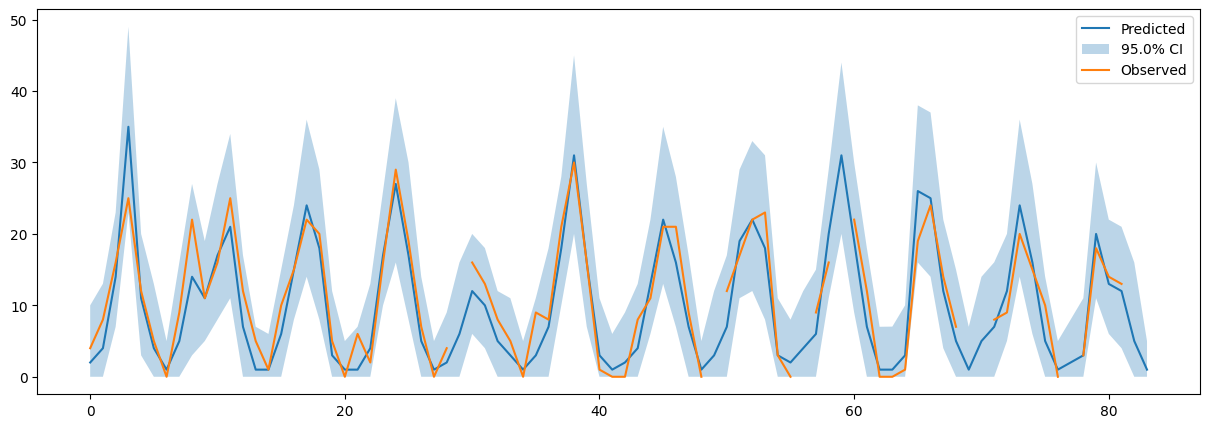

In [45]:
alpha = 0.05

posterior = posterior_120_dpo_july.posterior

y_pred_obs = posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_miss = posterior.y_pred_miss.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred = pd.concat([pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_obs_index),
                                  pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_miss_index)]).sort_index()
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_pred_miss = pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2*100}%'], y_pred.loc[xx, f'{(1-alpha/2)*100}%'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed')
plt.legend()
plt.show()

In [46]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120']) | (y_star_up < Y_obs['Count_120']))[0]
print(outliers)
print(outliers.shape)

[ 309  391  422  429  478  481  512  513  519  585  599  695  701  753
  757  769  770  775  781  863  876  917  919  920  921  950  962  984
 1016 1021 1026 1073 1222 1331 1407 1527 1540 1611 1774 1889 1978 1983
 1989 2026 2119 2140 2221 2227 2234 2251 2399 2460 2464 2711 2718 2740
 2741 2746 2748 2749 2761 2785 2812 2832 2833 2920 3014 3028 3041 3095
 3161 3232 3246 3319 3359 3427 3430 3434 3446 3449 3503 3522 3526 3607
 3608 3694]
(86,)


In [47]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

0.9776041666666667


[   3   79  409  591  625  674  867  913 1086 1121 1170 1177 1353 1387
 1435 1533 1616 1919 2091 2139 2387 2599 2648 2655 2686 2700 2734 2735
 2906 2913 2996 3022 3035 3084 3122 3376 3423 3545 3629 3757 3788]
(41,)
[ 391  410  429  478  513  585  599  695  701  770  842  876  920  950
 1016 1021 1222 1407 1408 1527 1889 1978 1983 2119 2137 2140 2221 2251
 2399 2648 2655 2659 2663 2718 2719 2735 2746 2761 2832 2833 3014 3028
 3042 3095 3423 3430 3522 3526 3600 3608 3694]
(51,)


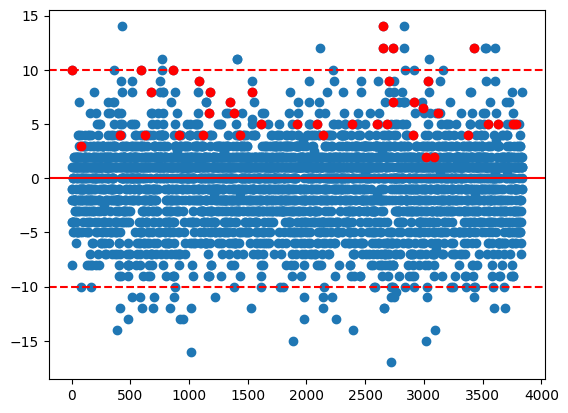

In [48]:
idx_over_max = np.where(y_star > max_month_obs)[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120']
residuals = np.abs(res.values)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [49]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

2.753776041666667
13.731705729166666


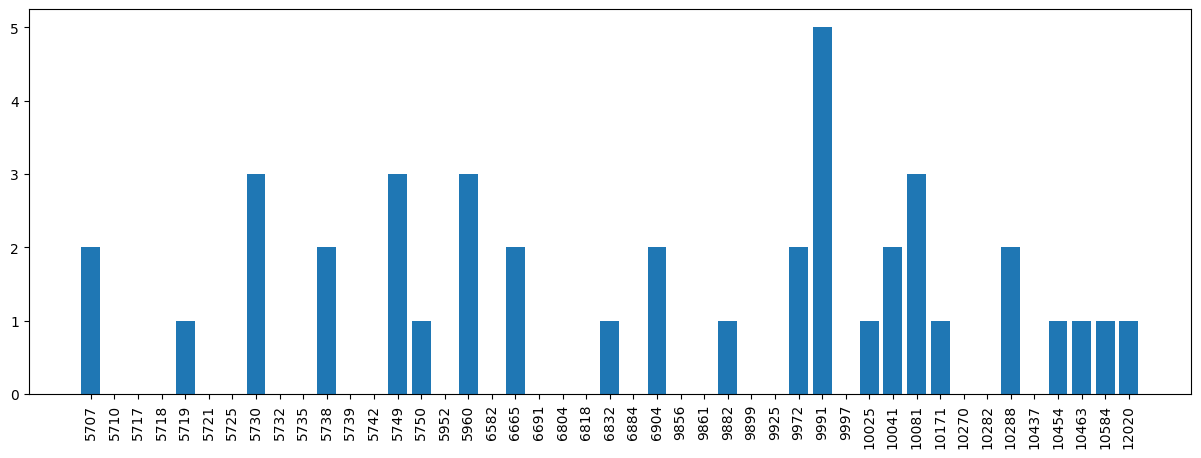

In [50]:
# Count how many outliers we have per station
outliers_per_station = pd.Series(np.zeros(45), index=stations_obs.unique())
for i in idx_over_max:
    outliers_per_station[stations_obs[i]] += 1
outliers_per_station = outliers_per_station.astype(int)
outliers_per_station.index = outliers_per_station.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_station.index, outliers_per_station)
plt.xticks(rotation=90)
plt.show()

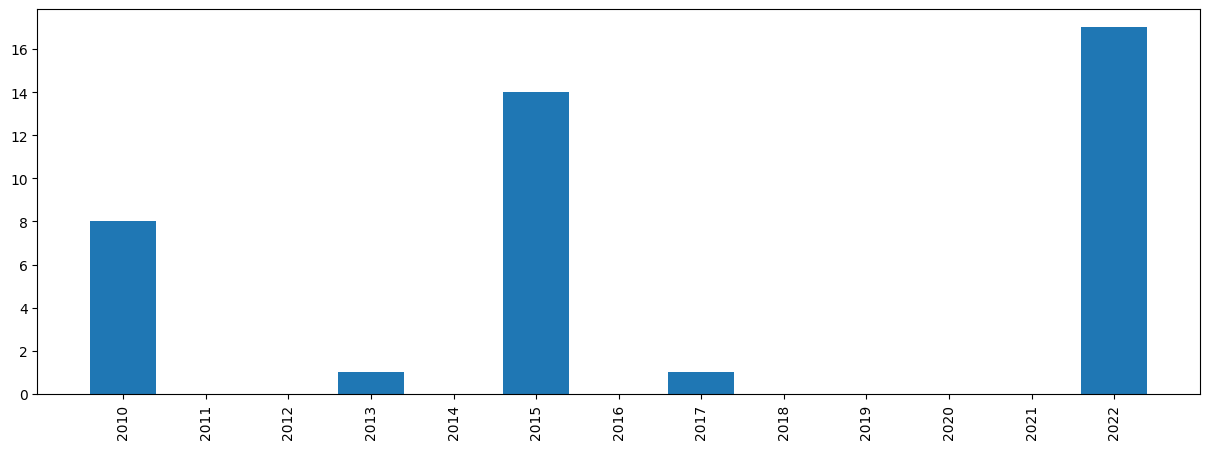

In [51]:
# Count how many outliers we have per year
outliers_per_year = pd.Series(np.zeros(13), index=years_raw_obs.unique())
for i in idx_over_max:
    outliers_per_year[years_raw_obs[i]] += 1
outliers_per_year = outliers_per_year.astype(int)
outliers_per_year.index = outliers_per_year.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_year.index, outliers_per_year)
plt.xticks(rotation=90)
plt.show()

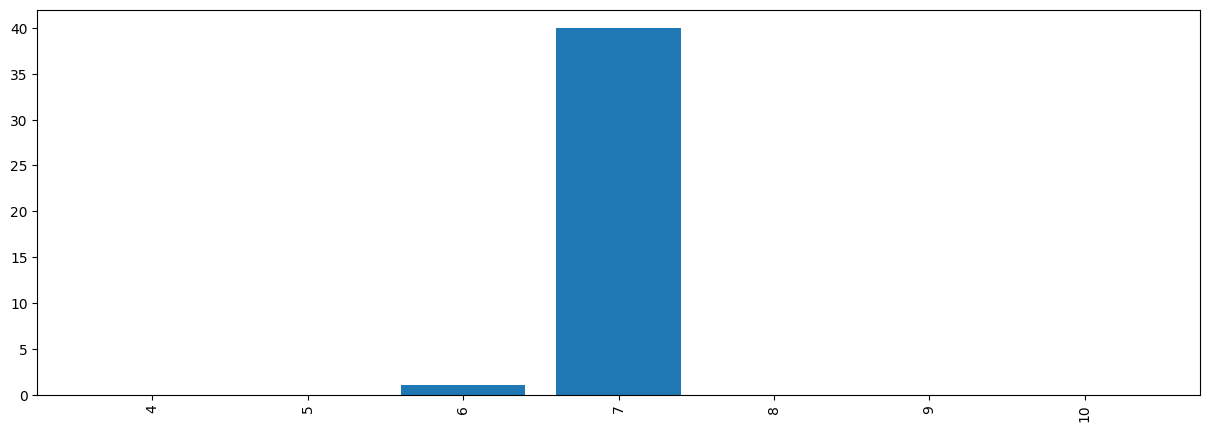

In [52]:
# Count how many outliers we have per month
outliers_per_month = pd.Series(np.zeros(7), index=months_raw_obs.unique())
for i in idx_over_max:
    outliers_per_month[months_raw_obs[i]] += 1
outliers_per_month = outliers_per_month.astype(int)
outliers_per_month.index = outliers_per_month.index.astype(str)

plt.figure(figsize=(15, 5))
plt.bar(outliers_per_month.index, outliers_per_month)
plt.xticks(rotation=90)
plt.show()

In [53]:
Models_df.loc['model_120_dpo_july'] = [mae, mse, percentage_inside, idx_over_max.shape[0]]
print(Models_df)

                         MAE        MSE  inside CI  outliers
model_120_dpo       2.761458  13.736979   0.976562      40.0
model_120_dpo_july  2.753776  13.731706   0.977604      41.0


# Ordered Logistic

In [54]:
model_120_ologit = FetchModel('model_120_ologit').compile()

In [55]:
data_120_ologit = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),
    "P": X_obs_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": transformed_stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,
    "y": Y_obs['Count_120'] + 1,
    "X_miss": X_miss_std,
    "X": X_obs_std,
    "phi": phi,
    "distances": distances
}

fit_120_ologit = model_120_ologit.sample(data=data_120_ologit, chains=4, parallel_chains=4,
    iter_warmup=500, iter_sampling=500)
posterior_120_ologit = az.from_cmdstanpy(fit_120_ologit)

13:25:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▊         | 00:00 Status





chain 1 |█▋        | 03:38 Iteration:   1 / 1000 [  0%]  (Warmup)


chain 1 |██▌       | 05:36 Iteration: 100 / 1000 [ 10%]  (Warmup)


chain 1 |███▎      | 07:12 Iteration: 200 / 1000 [ 20%]  (Warmup)


chain 1 |████▏     | 08:35 Iteration: 300 / 1000 [ 30%]  (Warmup)





chain 1 |█████▊    | 10:06 Iteration: 500 / 1000 [ 50%]  (Warmup)


chain 1 |██████▋   | 11:28 Iteration: 501 / 1000 [ 50%]  (Sampling)


chain 1 |███████▌  | 12:57 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |████████▎ | 14:22 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████████▏| 15:44 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 17:55 Sampling completed                      
chain 2 |██████████| 17:55 Sampling completed                      
chain 3 |██████████| 17:55 Sampling completed                      
chain 4 |██████████| 17:55 Sampling complet


13:43:26 - cmdstanpy - INFO - CmdStan done processing.
13:43:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_ologit.stan', line 53, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'model_120_ologit.stan', line 53, column 2 to column 63)
	Exception: ordered_logistic: Location parameter is inf, but must be finite! (in 'model_120_ologit.stan', line 71, column 6 to column 47)
	Exception: ordered_logistic: Location parameter is inf, but must be finite! (in 'model_120_ologit.stan', line 71, column 6 to column 47)
	Exception: ordered_logistic: Location parameter is inf, but must be finite! (in 'model_120_ologit.stan', line 71, column 6 to column 47)
	Exception: ordered_logistic: Location parameter is inf, but must be finite! (in 'model_120_ologit.stan', line 74, column 6 to column 47)
	Exception: cholesky_decompose: A is no

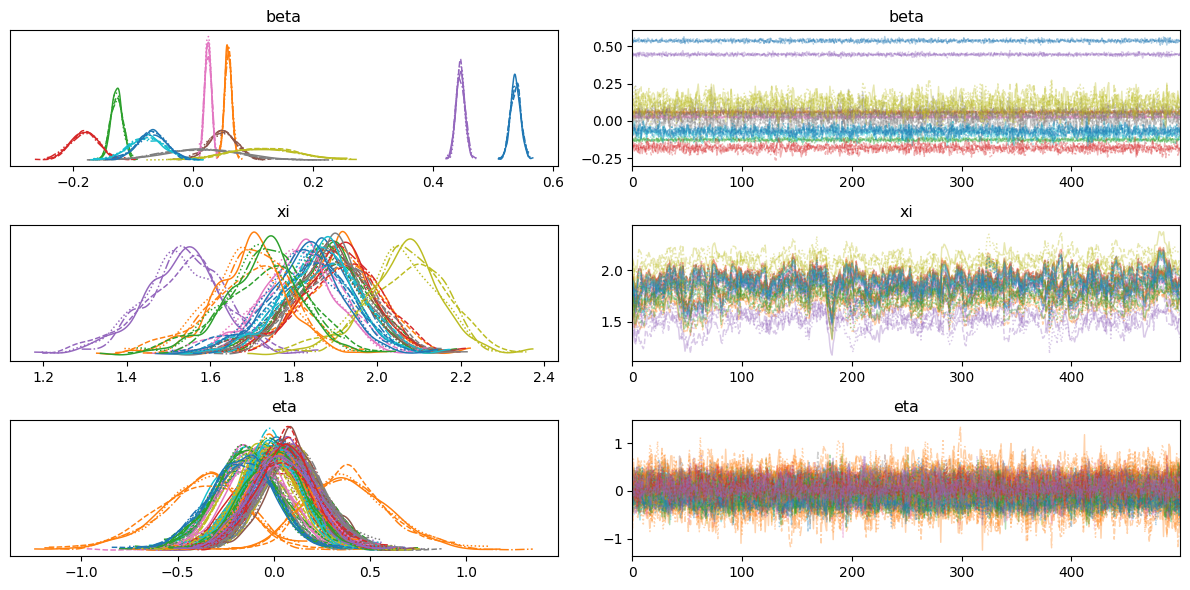

In [56]:
az.plot_trace(posterior_120_ologit, var_names=['beta', 'xi', 'eta'], compact=True)
plt.tight_layout()
plt.show()

In [57]:
posterior_120_ologit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [58]:
posterior_120_ologit_med = posterior_120_ologit.posterior.median(dim=['chain', 'draw'])
posterior_120_ologit_med

<xarray.Dataset>
Dimensions:               (beta_dim_0: 11, eta_dim_0: 45, xi_dim_0: 13,
                           w_dim_0: 45, lambda_dim_0: 3840,
                           fix_eff_dim_0: 3840, intercept_dim_0: 3840,
                           lambda_miss_dim_0: 255, fix_eff_miss_dim_0: 255,
                           intercept_miss_dim_0: 255, Sigma_s_dim_0: 45,
                           Sigma_s_dim_1: 45, Lw_dim_0: 45, Lw_dim_1: 45,
                           y_pred_dim_0: 3840, y_pred_miss_dim_0: 255)
Coordinates: (12/16)
  * beta_dim_0            (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * eta_dim_0             (eta_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * xi_dim_0              (xi_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * w_dim_0               (w_dim_0) int32 0 1 2 3 4 5 6 ... 38 39 40 41 42 43 44
  * lambda_dim_0          (lambda_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * fix_eff_dim_0         (fix_eff_dim_0) int32 0 1 2 3 ... 3836 3837 3838 3839
    ...                    ...
  * Sigma_s_dim_0         (Sigma_s_dim_0) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Sigma_s_dim_1         (Sigma_s_dim_1) int32 0 1 2 3 4 5 ... 40 41 42 43 44
  * Lw_dim_0              (Lw_dim_0) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * Lw_dim_1              (Lw_dim_1) int32 0 1 2 3 4 5 6 ... 39 40 41 42 43 44
  * y_pred_dim_0          (y_pred_dim_0) int32 0 1 2 3 4 ... 3836 3837 3838 3839
  * y_pred_miss_dim_0     (y_pred_miss_dim_0) int32 0 1 2 3 ... 251 252 253 254
Data variables: (12/16)
    beta                  (beta_dim_0) float64 0.5371 0.05836 ... -0.06839
    eta                   (eta_dim_0) float64 0.08717 -0.01745 ... 0.03663
    xi                    (xi_dim_0) float64 1.862 1.907 1.88 ... 1.7 1.732
    w                     (w_dim_0) float64 0.2384 0.08918 ... 0.198 0.08591
    sigma                 float64 0.2819
    sigma0                float64 0.2159
    ...                    ...
    fix_eff_miss          (fix_eff_miss_dim_0) float64 0.04089 ... 0.2089
    intercept_miss        (intercept_miss_dim_0) float64 1.861 2.216 ... 1.96
    Sigma_s               (Sigma_s_dim_0, Sigma_s_dim_1) float64 0.07945 ... ...
    Lw                    (Lw_dim_0, Lw_dim_1) float64 0.2819 0.0 ... 0.2244
    y_pred                (y_pred_dim_0) float64 4.0 6.0 15.0 ... 15.0 5.0 3.0
    y_pred_miss           (y_pred_miss_dim_0) float64 7.0 5.0 6.0 ... 2.0 9.0

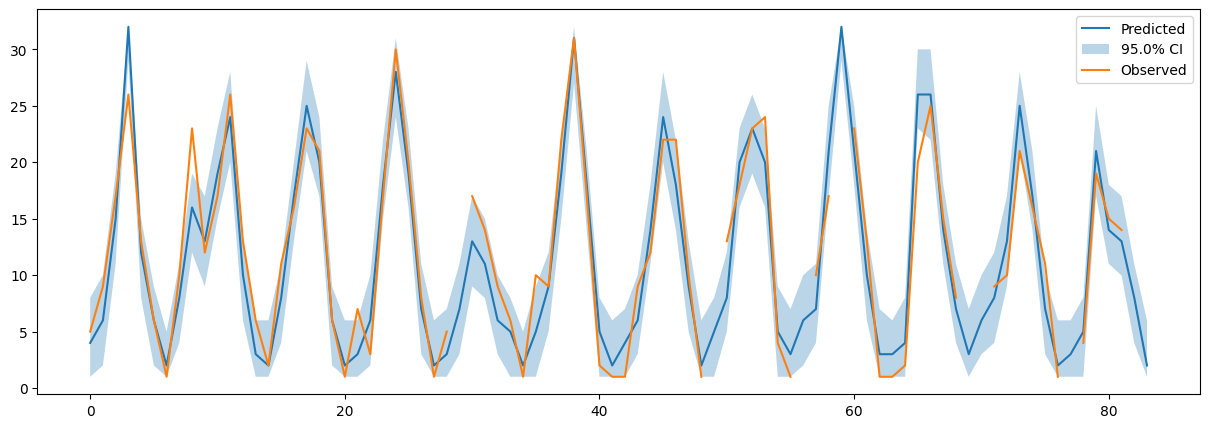

In [59]:
alpha = 0.05

posterior = posterior_120_ologit.posterior

y_pred_obs = posterior.y_pred.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred_miss = posterior.y_pred_miss.quantile([0.5, alpha/2, 1-alpha/2], dim=['chain','draw'])
y_pred = pd.concat([pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_obs_index),
                                  pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'], index=Y_miss_index)]).sort_index()
y_pred_obs = pd.DataFrame(y_pred_obs.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])
y_pred_miss = pd.DataFrame(y_pred_miss.T.values, columns=['pred', f'{alpha/2*100}%', f'{(1-alpha/2)*100}%'])

y_star = y_pred_obs['pred']
y_star_low = y_pred_obs[f'{alpha/2*100}%']
y_star_up = y_pred_obs[f'{(1-alpha/2)*100}%']

# Plot the predictions with the real values skipping the plot of the NA values
Y_data = np.array(Y['Count_120'])
Y_data[rows_to_drop_Y] = np.nan
station_num_to_plot = 1 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(12*7*(station_num_to_plot-1), 12*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200)
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2*100}%'], y_pred.loc[xx, f'{(1-alpha/2)*100}%'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx] + 1, label='Observed')
plt.legend()
plt.show()

In [60]:
# We identify the outliers using the 95% confidence interval
outliers = np.where((y_star_low > Y_obs['Count_120'] + 1) | (y_star_up < Y_obs['Count_120'] + 1))[0]
print(outliers)
print(outliers.shape)

[   3    8   21   34   48   51   61   69   80   83   92  119  132  141
  143  145  154  157  160  165  166  169  173  176  181  193  205  211
  219  227  234  238  239  250  259  266  278  285  286  293  308  309
  310  322  338  343  346  350  351  363  364  365  371  385  391  394
  396  397  402  403  404  407  410  413  414  420  422  423  424  428
  429  430  472  477  478  479  481  482  485  486  493  499  512  513
  519  525  544  545  551  557  558  571  581  582  583  584  585  591
  592  599  605  609  612  613  618  634  643  645  648  650  657  658
  662  665  669  673  674  675  680  681  682  685  688  689  690  695
  701  702  706  718  724  733  739  741  744  747  751  753  757  759
  767  768  769  770  771  774  775  776  777  781  782  799  801  802
  807  815  818  824  826  832  842  846  850  855  861  862  863  864
  867  869  873  874  876  877  878  884  898  901  908  911  914  917
  919  920  921  950  955  961  962  970  998 1006 1009 1012 1016 1019
 1021 

In [61]:
# Percentage of observations inside the 95% confidence interval
percentage_inside = 1 - outliers.shape[0] / Y_obs.shape[0]
print(percentage_inside)

0.8046875


[]
(0,)
[ 391  410  429  478  695  701  769  770  842  876  920  950 1016 1021
 1407 1408 1527 1540 1889 1983 2119 2140 2251 2399 2659 2718 2746 2761
 2832 2833 2839 2920 3014 3028 3042 3095 3430 3522 3526 3600 3608 3694]
(42,)


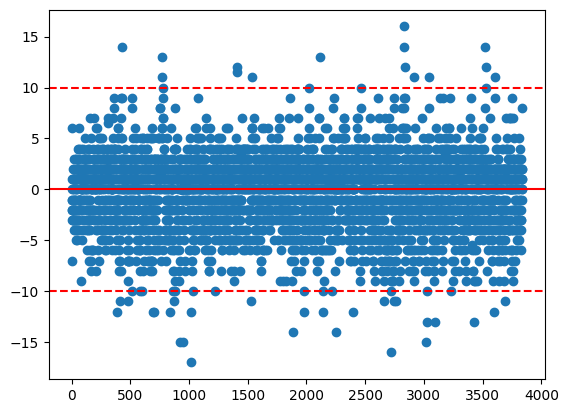

In [62]:
idx_over_max = np.where(y_star > (max_month_obs + 1))[0]
print(idx_over_max)
print(idx_over_max.shape)

res = y_star - Y_obs['Count_120'] - 1
residuals = np.abs(res.values)

res_over_10 = np.where(residuals > 10)[0]
print(res_over_10)
print(res_over_10.shape)

#plot these residuals
plt.scatter(np.arange(0, len(res)),res)
plt.scatter(idx_over_max, res[idx_over_max], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='--')
plt.axhline(y=-10, color='r', linestyle='--')
plt.show()

In [64]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

2.642447916666667
12.383984375


In [68]:
Models_df.loc['model_120_ologit'] = [mae, mse, percentage_inside, idx_over_max.shape[0]]
print(Models_df)

                         MAE        MSE  inside CI  outliers
model_120_dpo       2.761458  13.736979   0.976562      40.0
model_120_dpo_july  2.753776  13.731706   0.977604      41.0
model_120_ologit    2.642448  12.383984   0.804688       0.0
